Step 1: Connecting to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


Step 2: Download the LC25000 Dataset directly from the Kaggle website.

In [2]:
import os
! pip install -q kaggle

In [3]:
cp /content/drive/MyDrive/kaggle.json /content


In [4]:
! chmod 600 /content/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
! unzip /content/lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

Step 3: Import the Requirements

In [6]:
import itertools
import cv2
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Reshape, Permute, multiply, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from glob import glob
from tensorflow.keras import backend

Step 4: - Make a new Directory ("LungColon") and copy all the Lung and Colon images in this Directory.

Copying files...
All files copied successfully!
New Paths:  ['/content/LungColon/lung_n', '/content/LungColon/lung_scc', '/content/LungColon/colon_n', '/content/LungColon/lung_aca', '/content/LungColon/colon_aca']
Images Count:  25000


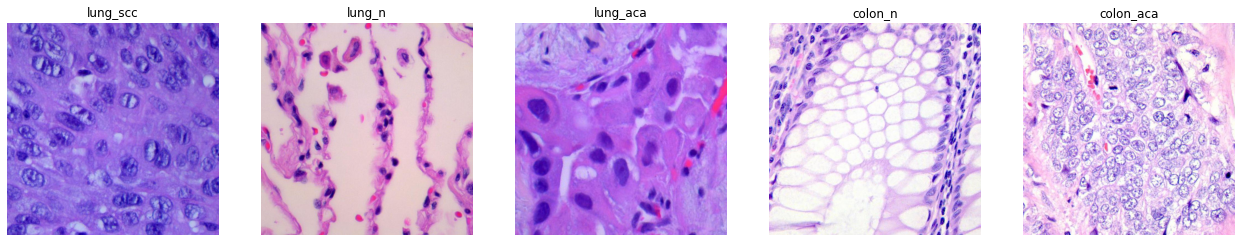

In [7]:
# Make a new directory and copy all of the images to that directory.

!mkdir /content/LungColon

print('Copying files...')
!cp -R /content/lung_colon_image_set/colon_image_sets/* ./LungColon
!cp -R /content/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

# Checking the number of classes and images in the new directory.

folders = glob('/content/LungColon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('/content/LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))


# Plotting some sample images of different Classes.

SAMPLES = ['/content/LungColon/lung_scc/lungscc1.jpeg', '/content/LungColon/lung_n/lungn1.jpeg', 
           '/content/LungColon/lung_aca/lungaca1.jpeg', '/content/LungColon/colon_n/colonn1.jpeg', 
           '/content/LungColon/colon_aca/colonca1.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')


Step 5: Prepare the Training and the Validation Data for Training the network.
        Rescaling and Resizing the images are also performed in this step.

In [8]:
data_dir = '/content/LungColon'
BATCH_SIZE = 128
X = Y = 224
data = ImageDataGenerator(samplewise_center=False, samplewise_std_normalization=False, rescale=1./255, data_format=None, validation_split=0.2)
training = data.flow_from_directory(directory = data_dir, target_size = (X, Y), color_mode="rgb",class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=42, subset="training")
validation = data.flow_from_directory(directory = data_dir, target_size = (X, Y), color_mode="rgb",class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False, seed=42, subset="validation")


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


Step 6: Defining The Squeeze and Excitation Block (SE Block)

In [9]:
backend.set_image_data_format('channels_last')

def squeeze_excite_block(input, ratio=16):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if backend.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

Step 7: Select the feature Descriptor (NasNetMobile, VGG16, Resnet50) and train the model.

In [10]:
K = len(folders)

# Select the feature Descriptor by commenting and uncommenting:

# VGG16:
# model= keras.applications.VGG16(input_shape= (X, Y, 3), include_top= False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

# NasNetMobile:
model= keras.applications.NASNetMobile(input_shape= (X, Y, 3), include_top= False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

# Resnet50:
# model= keras.applications.ResNet50(input_shape= (X, Y, 3), include_top= False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)



# Defining the MLP Classifier and building the model:
model.trainable = False
x = model.output
x=squeeze_excite_block(x, ratio=6)
x=GlobalAveragePooling2D()(x)
x = Dense(500)(x)
x = Dense(100)(x)
predictions = Dense(K, activation="softmax")(x)
model = keras.models.Model(inputs=model.input, outputs=predictions)


20004864/19993432 [==============================] - 0s 0us/step


Step 8: Compiling the model

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Step 9 : Training the model

In [ ]:
# Define two callbacks for saving the model with the highest Val_Acuracy and making a history file (log file) file of the training process.
callback_model= keras.callbacks.ModelCheckpoint( '/content' + '/model.h5', monitor= "val_accuracy", verbose= 1, save_best_only= True, mode= "max")
callback_CSV= keras.callbacks.CSVLogger('/content' + "/model.log", append=True)

# Training the model
history = model.fit_generator(training, steps_per_epoch= len(training),  epochs=50, verbose=1, validation_data=validation, validation_steps= len(validation), callbacks=[callback_model, callback_CSV])

Step 10: Plott the graph of loss and accuracy of the network.

2
2


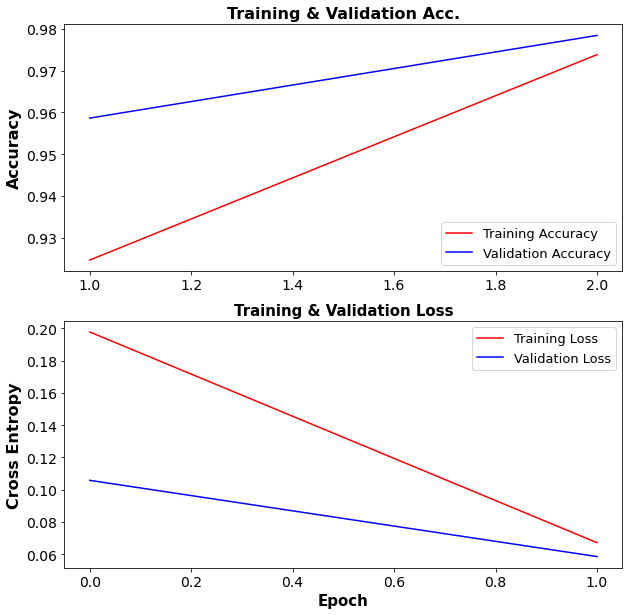

In [13]:

import pandas as pd
data = pd.read_csv('/content/model.log', delimiter = ",", header = None)
epoch = np.array(data[0][1:]).astype(float) + 1
accuracy = np.array(data[1][1:]).astype(float)
loss = np.array(data[2][1:]).astype(float)
val_accuracy = np.array(data[3][1:]).astype(float)
val_loss = np.array(data[4][1:]).astype(float)

print(len(epoch))
print(len(accuracy))

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epoch, accuracy, label='Training Accuracy', color='r')
plt.plot(epoch, val_accuracy, label='Validation Accuracy', color='b')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

Step 11: Calculating the Precision, Recall, and F1-score

In [14]:
from sklearn.metrics import classification_report

# Loading the model
model= keras.models.load_model("/content/model.h5")    

# Comput different metrics

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      1.00      1.00      1000
           2       0.95      0.96      0.95      1000
           3       1.00      1.00      1.00      1000
           4       0.96      0.95      0.95      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



Step 12: Calculate and plot the Confusion Matrix

Normalized confusion matrix


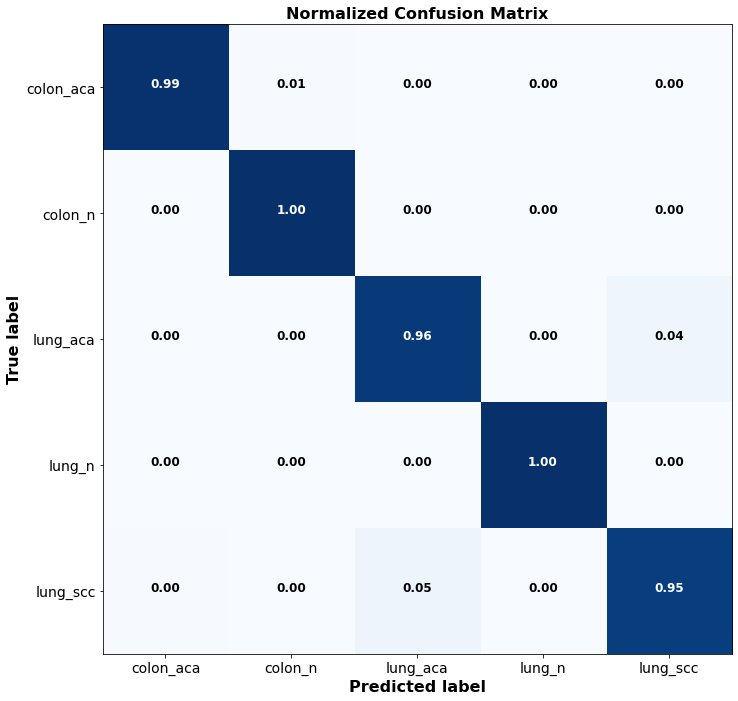

In [15]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.show()

Step 13: Plot the feature maps of some layers of the network for a sample input image

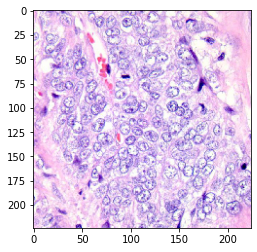

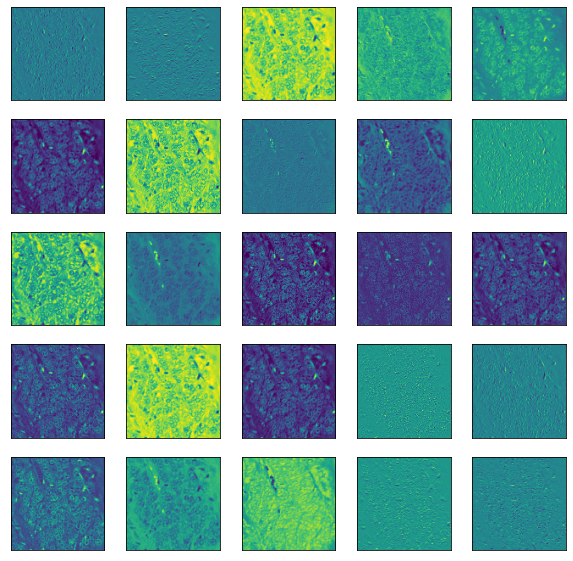

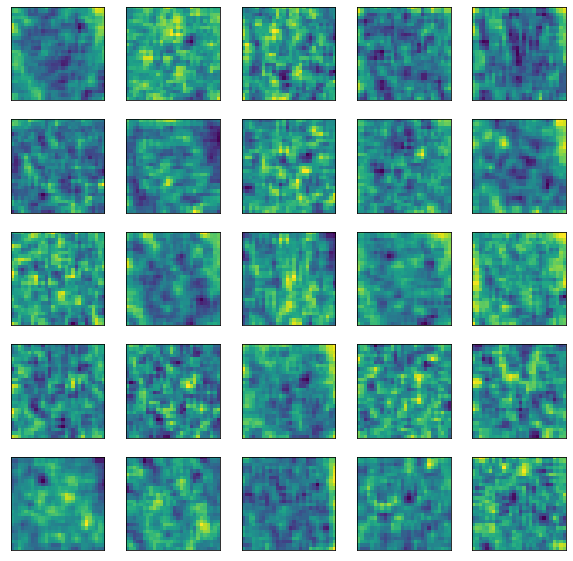

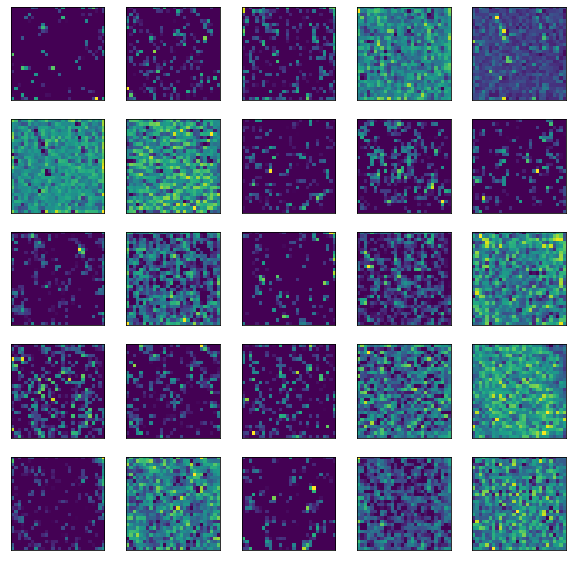

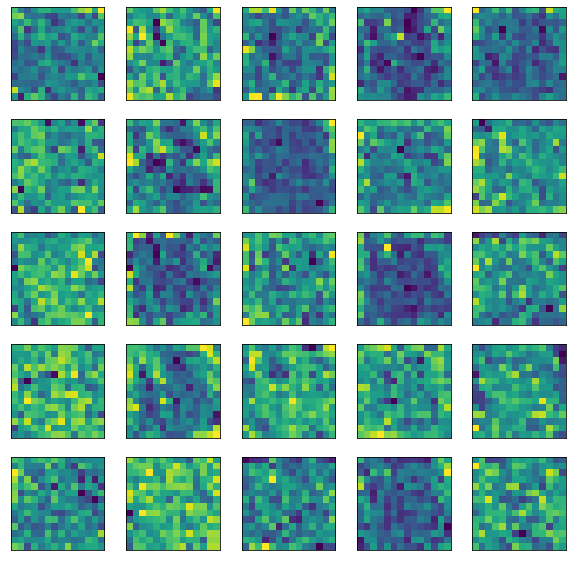

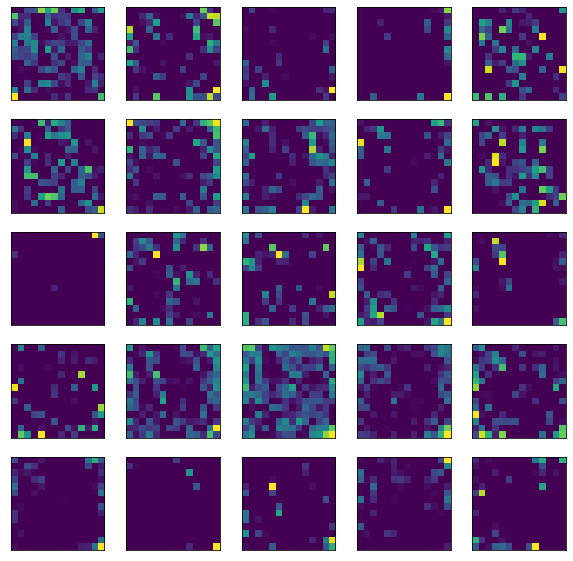

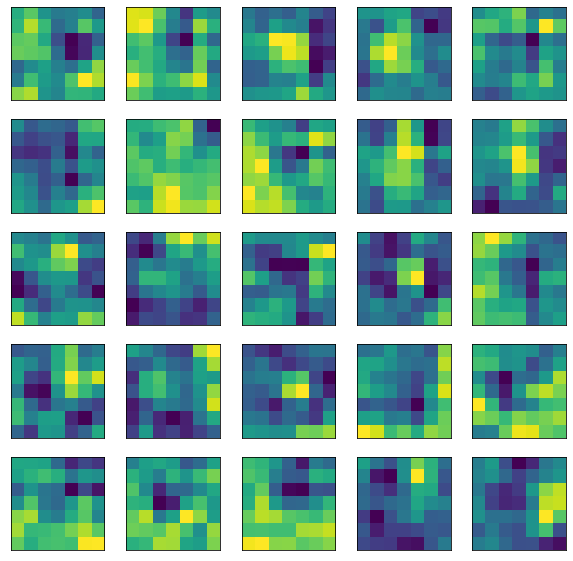

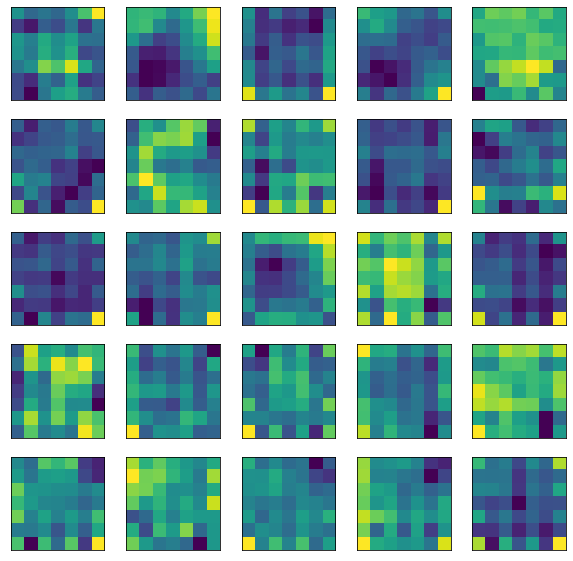

In [20]:
# Plot the sample Image
plt.imshow(validation[0][0][0])

# Build a model for plotting the feature maps
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
feature_maps  = feature_map_model.predict(np.expand_dims(validation[0][0][0],axis = 0))

# Select some layers of the network and plot the feature maps
feature_maps_list = [1,150,250,350,450,550,650]
square = 5
for fmap in feature_maps_list:
  ix = 1
  plt.figure(figsize=(10,10))
  for _ in range(square):
    for _ in range(square):
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps[fmap][0][:,:,ix-1])
      ix += 1
  plt.show()

Step14: Copute the attention map for the actived class using GradCam

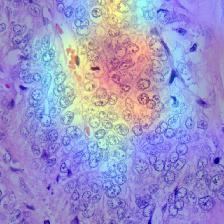

<Figure size 432x288 with 0 Axes>

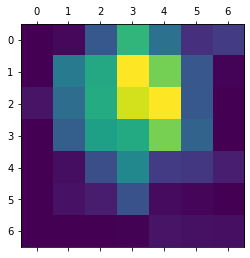

<Figure size 432x288 with 0 Axes>

In [23]:

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap/255) * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


# Generate class activation heatmap

layer_outputs = [layer.name for layer in model.layers]
last_conv_layer_name = layer_outputs[-10]
heatmap = make_gradcam_heatmap(np.expand_dims(validation[0][0][0],axis = 0), model, last_conv_layer_name)

# Display heatmap
plt.figure();plt.matshow(heatmap)

plt.figure();save_and_display_gradcam(validation[0][0][0], heatmap)


